# Comparison of t-test, bootstrap, permutation test output results

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare
from mlxtend.evaluate import permutation_test

In [6]:
import string
import random

def get_random_alnum_str(length):
    letters_and_digits = string.ascii_letters + string.digits
    result_str = ''.join((random.choice(letters_and_digits) for i in range(length)))
    return result_str

## Generate the test set by running a power analysis

In [60]:
es = (100 - 105) / 40 # calculating an effect size M_1 - M_2 / SD_polled 

In [61]:
import statsmodels.stats.api as sms
sms.TTestIndPower().solve_power(effect_size=es, power=0.8, nobs1=None, ratio=1, alpha=0.05)

1005.6154263659035

In [8]:
# Generate synthetic data
def generate_data(n=1000, mean=100, delta=5, sd=40, iterations=1000):
    norm1 = np.random.normal(loc=mean, scale=sd, size=n*iterations)
    norm2 = np.random.normal(loc=mean+delta, scale=sd, size=n*iterations)
    iter_list = [i//n + 1 for i in range(iterations*n)]
    
    norm1_df = pd.DataFrame({'subject_id': [get_random_alnum_str(16) for i in range(iterations*n)],
                             'experiment_group': ['control' for i in range(iterations*n)],
                             'metric': norm1,
                             'iteration': iter_list})
    norm2_df = pd.DataFrame({'subject_id': [get_random_alnum_str(16) for i in range(iterations*n)],
                             'experiment_group': ['treatment' for i in range(iterations*n)],
                             'metric': norm2,
                             'iteration': iter_list})

    combined_df = norm1_df.append(norm2_df)

    return combined_df

In [9]:
generated_data = generate_data(sd=31)

In [10]:
generated_data

,subject_id,experiment_group,metric,iteration
0,hVod7dLrM2e14Tzp,control,111.869974,1
1,c9ndKogyzXqNnVe8,control,87.889825,1
2,k0AP4VERjyXbaK51,control,119.615202,1
3,QiJerQ1siTVr0sCO,control,115.205353,1
4,n9qwbmbKdEyndHky,control,95.601374,1
...,...,...,...,...
999995,WtMrl9SMN0WOOViK,treatment,111.018555,1000
999996,5K4sheERYTiwpHzZ,treatment,132.520019,1000
999997,Gb2eQiixHUzpexMj,treatment,89.845103,1000
999998,MroHNFCoXJx4VIWg,treatment,100.116606,1000


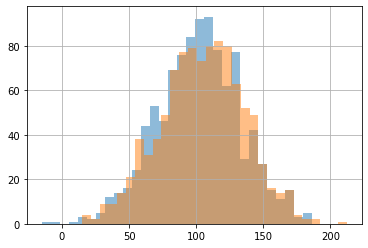

In [95]:
it = np.random.randint(1,1000)
generated_data.query("experiment_group == 'control' & iteration == @it")['metric'].hist(bins=30, alpha=.5)
generated_data.query("experiment_group == 'treatment' & iteration == @it")['metric'].hist(bins=30, alpha=.5);

In [34]:
def run_tests(data):
    iterations = data.iteration.unique()
    t_pvalues = np.zeros(iterations.shape)
    b_lowers = np.zeros(iterations.shape)
    b_uppers = np.zeros(iterations.shape)
    perm_pvalues = np.zeros(iterations.shape)

    for i in iterations:
        control = data.loc[(data['experiment_group'] == 'control') & (data['iteration'] == i), 'metric']
        treatment = data.loc[(data['experiment_group'] == 'treatment') & (data['iteration'] == i), 'metric']
        # run t-test
        _, t_pvalue = stats.ttest_ind(treatment, control, equal_var=False)
        t_pvalues[i-1] = t_pvalue

        # run bootstrap
        b = bs.bootstrap_ab(treatment.to_numpy(),
                            control.to_numpy(),
                            bs_stats.mean,
                            bs_compare.percent_change, # (test_stat - ctrl_stat) / ctrl_stat * 100
                            num_iterations=1000)
        b_lowers[i-1] = b.lower_bound
        b_uppers[i-1] = b.upper_bound

        # run permutation test
        perm_pvalue = permutation_test(treatment.to_numpy(), control.to_numpy(),
                                       method='approximate', num_rounds=1000, seed=0)
        perm_pvalues[i-1] = perm_pvalue

    results = pd.DataFrame({'iteration': iterations,
                            't_test_p_value': t_pvalues,
                            'bootstrap_lower': b_lowers,
                            'bootstrap_upper': b_uppers,
                            'perm_test_p_value': perm_pvalues
                           })
    results['t_test_sig'] = (results.t_test_p_value < 0.05).astype('int')
    results['bootstrap_sig'] = (results.bootstrap_lower > 0).astype('int')
    results['perm_test_sig'] = (results.perm_test_p_value < 0.05).astype('int')

    return results

In [35]:
results_df = run_tests(generated_data)

In [36]:
results_df

,iteration,t_test_p_value,bootstrap_lower,bootstrap_upper,perm_test_p_value,t_test_sig,bootstrap_sig,perm_test_sig
0,1,0.000266,2.267958,8.064992,0.001998,1,1,1
1,2,0.000002,3.682873,9.390375,0.000999,1,1,1
2,3,0.000092,2.631692,8.207522,0.000999,1,1,1
3,4,0.024011,0.307010,6.074444,0.014985,1,1,1
4,5,0.000951,1.747378,7.135463,0.002997,1,1,1
...,...,...,...,...,...,...,...,...
995,996,0.008969,0.967068,6.356559,0.005994,1,1,1
996,997,0.000390,2.132653,7.474928,0.000999,1,1,1
997,998,0.000157,2.576882,8.166442,0.000999,1,1,1
998,999,0.000006,3.616302,9.406029,0.000999,1,1,1


In [37]:
results_df[['t_test_sig', 'bootstrap_sig', 'perm_test_sig']].mean()

t_test_sig       0.960
bootstrap_sig    0.951
perm_test_sig    0.959
dtype: float64

In [35]:
generated_data.to_csv('~/Downloads/tests_python_data.csv', index=False)